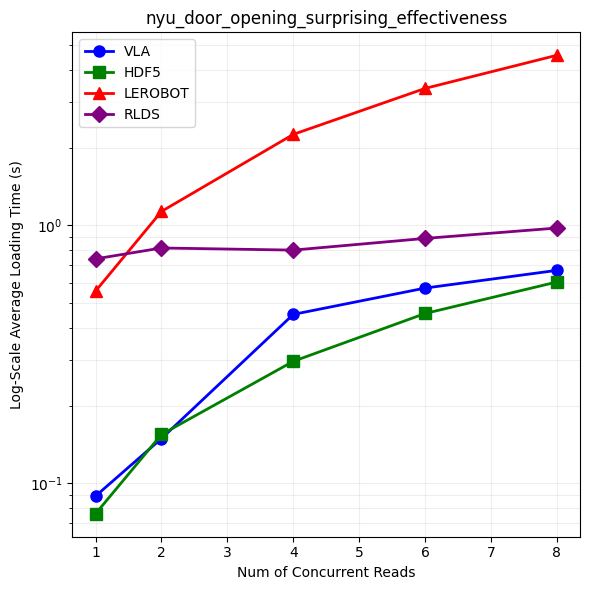

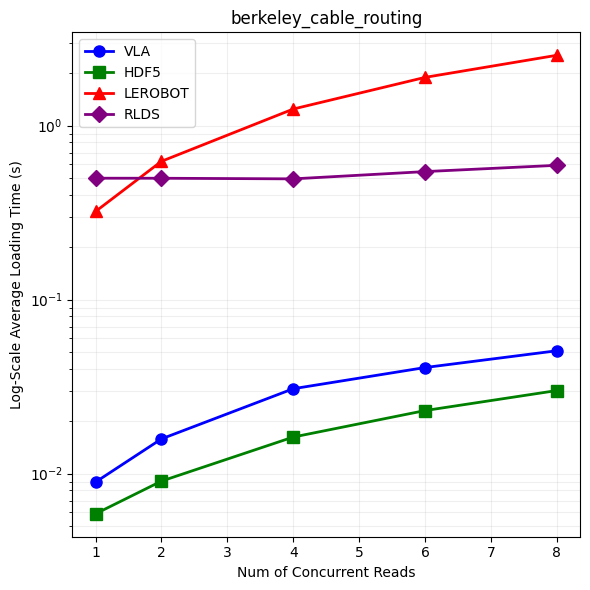

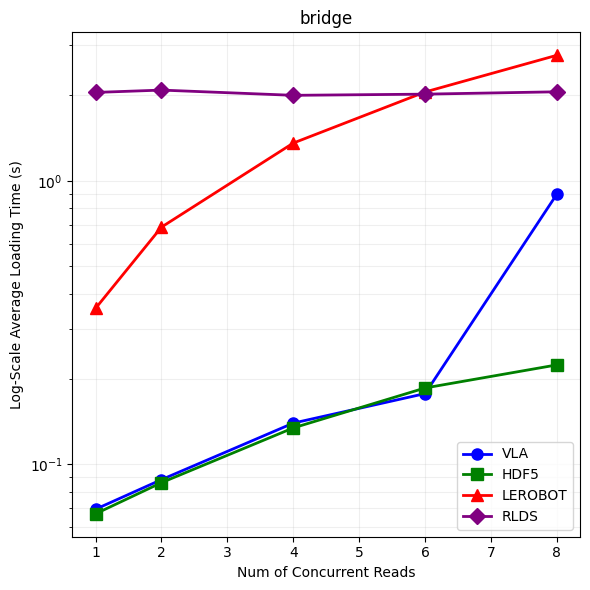

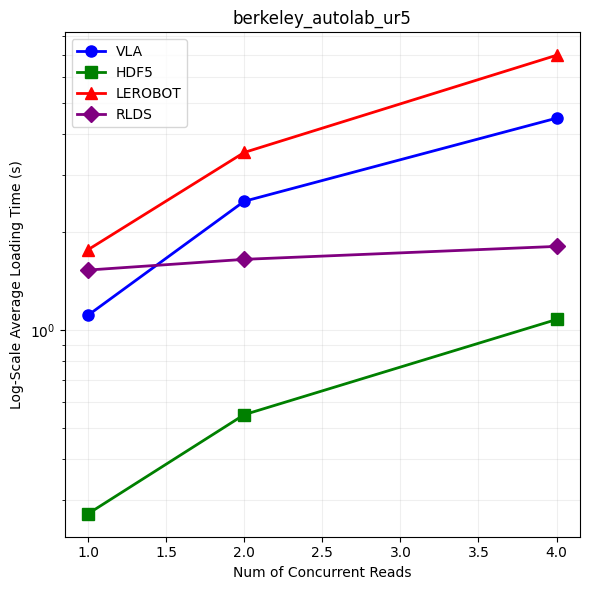

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Define colors and markers for each format
format_styles = {
    'VLA': ('blue', 'o'),
    'HDF5': ('green', 's'),
    'LEROBOT': ('red', '^'),
    'RLDS': ('purple', 'D')
}

# Get unique datasets and batch sizes
datasets = df['Dataset'].unique()

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the line plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        plt.plot(data['BatchSize'], data['AverageLoadingTime(s)'], 
                 color=color, marker=marker, label=format, linewidth=2, markersize=8)

    # Customize the plot
    plt.xlabel('Num of Concurrent Reads')
    plt.ylabel('Log-Scale Average Loading Time (s)')
    plt.title(f'{dataset}')
    plt.legend()
    # plt.xscale('log')  # Use log scale for x-axis
    plt.yscale('log')  # Use log scale for y-axis
    
    # Add a grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'./{dataset}.pdf')

In [7]:
# file size comparison per dataset per format as a table 
df.groupby(['Dataset', 'Format'])['AverageTrajectorySize(MB)'].mean()

Dataset                                    Format 
berkeley_autolab_ur5                       HDF5       281.554772
                                           LEROBOT      0.000000
                                           RLDS         0.000000
                                           VLA          1.851954
berkeley_cable_routing                     HDF5         4.866500
                                           LEROBOT      0.000000
                                           RLDS         0.000000
                                           VLA          0.678059
bridge                                     HDF5        29.909039
                                           LEROBOT      0.000000
                                           RLDS         0.000000
                                           VLA          0.311850
nyu_door_opening_surprising_effectiveness  HDF5        79.544284
                                           LEROBOT      0.000000
                                       

In [2]:
df

,Dataset,Format,Trajectory,LoadingTime(s),FileSize(MB),Throughput(traj/s)
0,berkeley_autolab_ur5,RLDS,0,0.045454,237.461549,22.000367
1,berkeley_autolab_ur5,RLDS,1,0.016615,126.826066,60.187754
2,berkeley_autolab_ur5,RLDS,2,0.017593,157.582145,56.839549
3,berkeley_autolab_ur5,RLDS,3,0.017673,157.047621,56.583439
4,berkeley_autolab_ur5,RLDS,4,0.026880,187.195036,37.203005
...,...,...,...,...,...,...
1275,nyu_door_opening_surprising_effectiveness,HDF5,59,0.019514,75.305054,51.246292
1276,nyu_door_opening_surprising_effectiveness,HDF5,60,0.016183,61.434937,61.792713
1277,nyu_door_opening_surprising_effectiveness,HDF5,61,0.028054,108.990044,35.645542
1278,nyu_door_opening_surprising_effectiveness,HDF5,62,0.019443,75.305054,51.432299


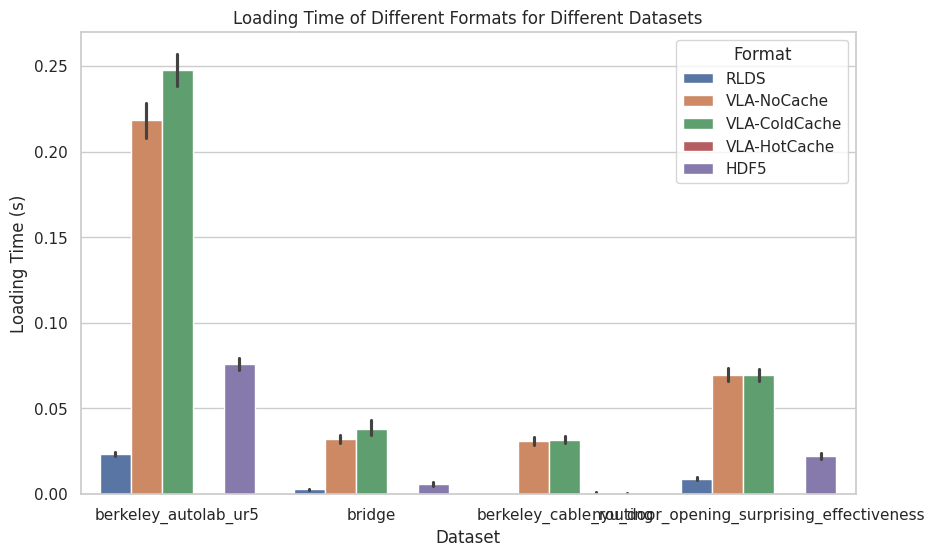

In [3]:
# visualize the data
# dataset to be the x axis, loading time is y axis, and format to be side by side comparison between different bars

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="LoadingTime(s)", hue="Format", data=df)
plt.title('Loading Time of Different Formats for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Loading Time (s)')
plt.show()


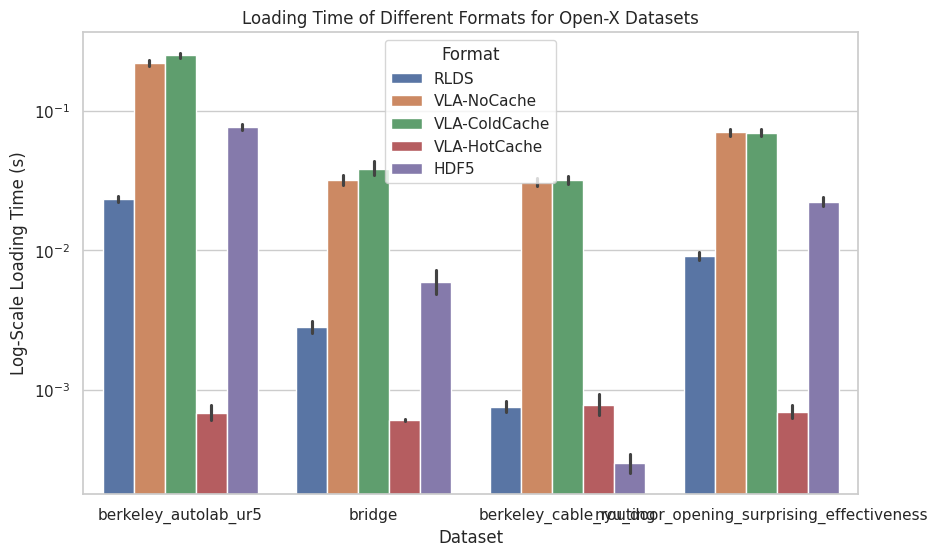

In [4]:
# make previous plot log scale
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="LoadingTime(s)", hue="Format", data=df)
plt.yscale('log')
plt.title('Loading Time of Different Formats for Open-X Datasets')
plt.xlabel('Dataset')
plt.ylabel('Log-Scale Loading Time (s)')
plt.show()


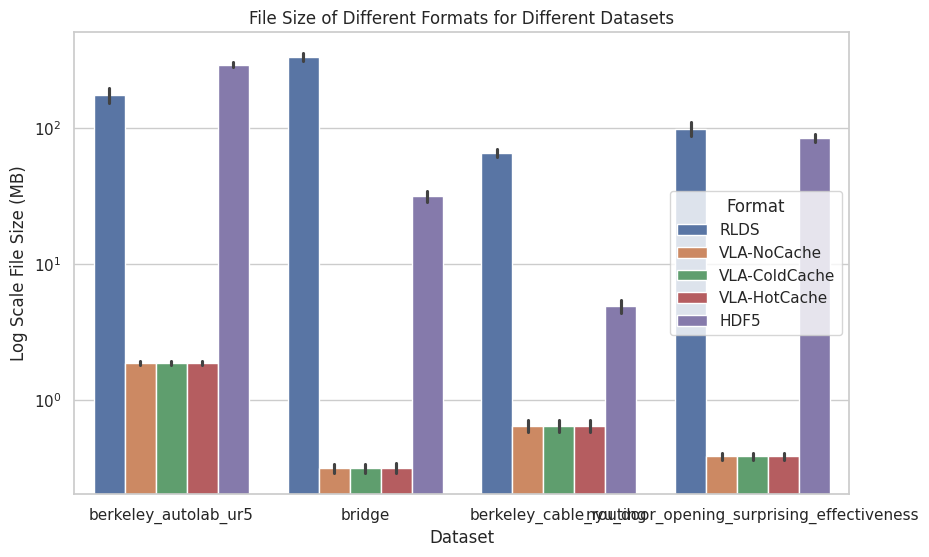

In [8]:
# file sze 
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="FileSize(MB)", hue="Format", data=df)
plt.yscale('log')
plt.title('File Size of Different Formats for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Log Scale File Size (MB)')
plt.show()

In [12]:
# get average loading time and storage for each dataset
df.groupby(['Dataset', 'Format'])['LoadingTime(s)'].mean()


Dataset                                    Format       
berkeley_autolab_ur5                       HDF5             0.075685
                                           RLDS             0.023251
                                           VLA-ColdCache    0.247777
                                           VLA-HotCache     0.000683
                                           VLA-NoCache      0.218245
berkeley_cable_routing                     HDF5             0.000300
                                           RLDS             0.000764
                                           VLA-ColdCache    0.031721
                                           VLA-HotCache     0.000788
                                           VLA-NoCache      0.030931
bridge                                     HDF5             0.005921
                                           RLDS             0.002830
                                           VLA-ColdCache    0.038200
                                           VLA

In [13]:
df.groupby(['Dataset', 'Format'])['FileSize(MB)'].mean()


Dataset                                    Format       
berkeley_autolab_ur5                       HDF5             289.032210
                                           RLDS             174.420469
                                           VLA-ColdCache      1.878984
                                           VLA-HotCache       1.878984
                                           VLA-NoCache        1.878984
berkeley_cable_routing                     HDF5               4.873406
                                           RLDS              65.382843
                                           VLA-ColdCache      0.645619
                                           VLA-HotCache       0.645619
                                           VLA-NoCache        0.645619
bridge                                     HDF5              31.268807
                                           RLDS             330.839012
                                           VLA-ColdCache      0.317214
                    

In [19]:
# compute the speedup of VLA to HDF5 and RLDS per dataset
df.groupby(['Dataset', 'Format'])['FileSize(MB)'].mean() / df.groupby(['Dataset', 'Format'])['LoadingTime(s)'].mean()

Dataset                                    Format       
berkeley_autolab_ur5                       HDF5               3818.869277
                                           RLDS               7501.680810
                                           VLA-ColdCache         7.583370
                                           VLA-HotCache       2752.311319
                                           VLA-NoCache           8.609527
berkeley_cable_routing                     HDF5              16256.118100
                                           RLDS              85611.650199
                                           VLA-ColdCache        20.353238
                                           VLA-HotCache        819.724171
                                           VLA-NoCache          20.873082
bridge                                     HDF5               5281.055338
                                           RLDS             116898.449382
                                           VLA-ColdCach